# Twitter sentiment analysis







### Dataset

The dataset was prepared based on the collection of [Twitter Sentiment Analysis](https://www.kaggle.com/jp797498e/twitter-entity-sentiment-analysis) and consist of:
-  `twitter_training.csv` - training set,
- `twitter_validation.csv` - test set.

## Code

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Reading datasets:

In [102]:
df_train= pd.read_csv("/content/drive/MyDrive/twitter_training.csv", encoding='latin-1')
df_test = pd.read_csv("/content/drive/MyDrive/twitter_validation.csv", encoding='latin-1')

First look on dataset structure:

In [103]:
df_train.head()

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [104]:
df_test.head()

,id,entity,sentiment,content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## **Data preprocessing:**

Deleting messages shorter than 4 chars:

In [105]:
df_train = df_train[df_train['content'].str.len()>4]
df_test = df_test[df_test['content'].str.len()>4]

Cleaning content (removing special characters, stopwords, etc):

In [106]:
stop_words = set(stopwords.words('english'))

def clear_doc(doc):
    doc = str(doc)
    doc = doc.lower()
    doc = re.sub(r'\d+', '', doc)
    doc = doc.strip()
    doc = " ".join([word for word in doc.split() if word not in stopwords.words('english')])
    doc = re.sub("@\S+", "", doc)
    doc = re.sub("\$", "", doc)
    doc = re.sub(r'http\S+', '', doc)
    doc = re.sub("#", "", doc)
    doc = " ".join([word for word in doc.split() if "_" not in word])
    doc = re.sub(r'\W+', ' ', doc)
    doc = ' '.join([w for w in doc.split() if len(w)>1])
    return doc

In [107]:
df_train['content_clear'] = df_train.apply(lambda row : clear_doc(row['content']), axis = 1)
df_test['content_clear'] = df_test.apply(lambda row : clear_doc(row['content']), axis = 1)
#df_train['content_clear'] = df_train['content']
#df_test['content_clear'] = df_test['content']

In [108]:
df_train.head()

,id,entity,sentiment,content,content_clear
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderlands murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill all
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill all
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder all
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder all


In [109]:
df_test.head()

,id,entity,sentiment,content,content_clear
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,mentioned facebook struggling motivation go ru...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon boss jeff bezos rejects claims...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,pay word functions poorly chromebook
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hacking truly awf...
4,4433,Google,Neutral,Now the President is slapping Americans in the...,president slapping americans face really commi...


Change values in Sentiment column from 'Irrelevant' to 'Neutral':

In [112]:
df_train.loc[df_train['sentiment'] == "Irrelevant", "sentiment"] = "Neutral"
df_test.loc[df_test['sentiment'] == "Irrelevant", "sentiment"] = "Neutral"

Train dataset vectorization:

In [110]:
from sklearn.feature_extraction.text import CountVectorizer

In [113]:
vectorizer = CountVectorizer(stop_words='english', max_df = 0.8)
vectorizer.fit(df_train["content_clear"])
text = df_train["content_clear"]
text_transformed_train = vectorizer.transform(text)
df_train['transformed'] = pd.DataFrame(data=text_transformed_train) 
df_train.head()

,id,entity,sentiment,content,content_clear,transformed
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderlands murder,"(0, 2892)\t1\n (0, 10286)\t1\n (0, 12465)\..."
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill all,"(0, 2896)\t1\n (0, 4742)\t1\n (0, 14064)\t1"
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill all,"(0, 2892)\t1\n (0, 10286)\t1\n (0, 12465)\..."
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder all,"(0, 2892)\t1\n (0, 4742)\t1\n (0, 12465)\t..."
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder all,"(0, 2892)\t1\n (0, 10286)\t1\n (0, 12465)\..."


Test dataset vectorization:



In [114]:
text = df_test["content_clear"]
text_transformed_test = vectorizer.transform(text)
df_test['transformed'] = pd.DataFrame(data=text_transformed_test) 
df_test.head()

,id,entity,sentiment,content,content_clear,transformed
0,3364,Facebook,Neutral,I mentioned on Facebook that I was struggling ...,mentioned facebook struggling motivation go ru...,"(0, 1572)\t1\n (0, 2142)\t1\n (0, 3614)\t1..."
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon boss jeff bezos rejects claims...,"(0, 219)\t1\n (0, 771)\t1\n (0, 1624)\t1\n..."
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,pay word functions poorly chromebook,"(0, 4261)\t1\n (0, 9850)\t1\n (0, 18749)\t..."
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hacking truly awf...,"(0, 1692)\t1\n (0, 4483)\t1\n (0, 5645)\t1..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...,president slapping americans face really commi...,"(0, 212)\t1\n (0, 217)\t1\n (0, 795)\t1\n ..."


New column with numerical values of sentiment:



In [115]:
def sentiment2number(df):
  conditions = [
    (df['sentiment'] == 'Positive'), #2
    (df['sentiment'] == 'Neutral'), #1
    (df['sentiment'] == 'Negative'), #0
    ]
    
  values = ['2', '1', '0']
  df['label'] = np.select(conditions, values)


In [116]:
sentiment2number(df_train)
sentiment2number(df_test)

## Data visualization

Topic histogram in train dataset:

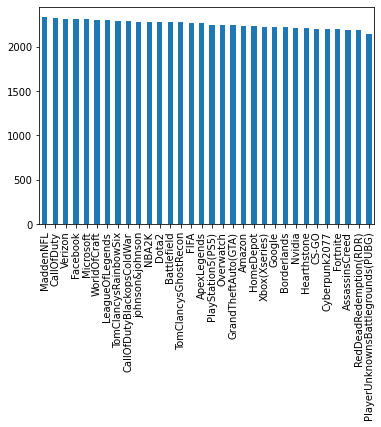

In [117]:
df_train['entity'].value_counts().plot(kind = 'bar')

Sentiment histogram:

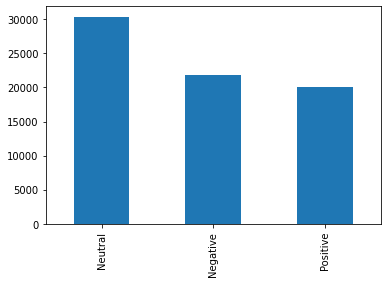

In [118]:
df_train['sentiment'].value_counts().plot(kind = 'bar')

Most frequent words:

In [119]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [120]:
common_words = get_top_n_words(df_train['content_clear'], 10)
for word, freq in common_words:
    print(word, freq)

com 9933
game 8245
like 4921
pic 4253
twitter 4186
get 3949
one 3634
good 3569
play 3469
new 3271


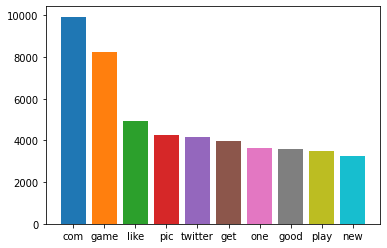

In [121]:
for word, freq in common_words:
    plt.bar(word, freq)

plt.show()

Word clouds for both sets:

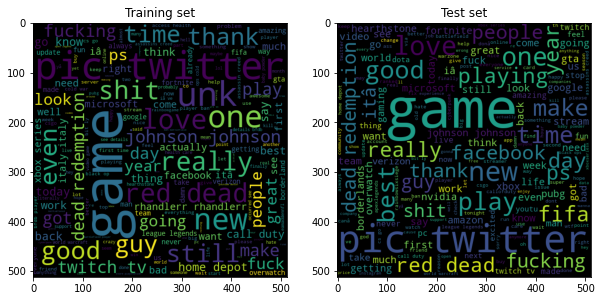

In [179]:
from wordcloud import WordCloud

words = " ".join(list(df_train['content_clear']))
words_plot_train = WordCloud(width = 512, height = 512).generate(words)

words = " ".join(list(df_test['content_clear']))
words_plot_test = WordCloud(width = 512, height = 512).generate(words)

fig, axes= plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(words_plot_train)
axes[0].title.set_text('Training set')
axes[1].imshow(words_plot_test)
axes[1].title.set_text('Test set')


## **Training:**

Classification report function:

In [122]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def printScores(model, X, Y):
    print("Accuracy score report:")
    acc = accuracy_score(Y, model.predict(X))
    print(acc)
    print()
    print("Classification report:")
    print(classification_report(Y, model.predict(X)))
    print("Confusion matrix:")
    print(confusion_matrix(Y, model.predict(X)))

    return acc

### **Naive Bayes model**

In [123]:
from sklearn.naive_bayes import MultinomialNB

In [124]:
%%time
model_Bayes = MultinomialNB()
model_Bayes.fit(text_transformed_train, df_train['label'])

CPU times: user 376 ms, sys: 1.85 ms, total: 378 ms
Wall time: 453 ms


Classification report:

In [167]:
acc = [] #accuracy list for models comparison
acc_names = []

In [168]:
bayes_acc = printScores(model_Bayes, text_transformed_test, df_test['label'])
acc.append(bayes_acc)
acc_names.append('Bayes')

Accuracy score report:
0.8289738430583501

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.81       262
           1       0.91      0.78      0.84       457
           2       0.78      0.88      0.83       275

    accuracy                           0.83       994
   macro avg       0.82      0.84      0.83       994
weighted avg       0.84      0.83      0.83       994

Confusion matrix:
[[228  15  19]
 [ 54 355  48]
 [ 16  18 241]]


## **Logistic regression:**

In [127]:
from sklearn.linear_model import LogisticRegression

In [128]:
%%time
model_reg = LogisticRegression(solver = 'lbfgs', max_iter=1000)
model_reg.fit(text_transformed_train, df_train["label"])

CPU times: user 48.6 s, sys: 43.7 s, total: 1min 32s
Wall time: 1min 9s


Classification report:

In [169]:
reg_acc = printScores(model_reg, text_transformed_test, df_test['label'])
acc.append(reg_acc)
acc_names.append("Linear reg")

Accuracy score report:
0.9336016096579477

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       262
           1       0.95      0.94      0.94       457
           2       0.92      0.91      0.92       275

    accuracy                           0.93       994
   macro avg       0.93      0.93      0.93       994
weighted avg       0.93      0.93      0.93       994

Confusion matrix:
[[249   8   5]
 [ 12 428  17]
 [  8  16 251]]


## **Deep neural network:**

Shape of input data:

In [131]:
text_transformed_train.shape

(72233, 29653)

One hot encoding of output:

In [132]:
from sklearn.preprocessing import OneHotEncoder

y = df_train['label']
one = OneHotEncoder(handle_unknown='ignore')
ya = np.array(y)
ya = ya.reshape(-1, 1)
y = one.fit_transform(ya).toarray()

y_test = df_test['label']
one = OneHotEncoder(handle_unknown='ignore')
y_test_a = np.array(y_test)
y_test_a = y_test_a.reshape(-1, 1)
y_test = one.fit_transform(y_test_a).toarray()

Neural network model:

In [148]:
def nn_model_l2(nNeurons, nHiddenLayers, inputWidth, outputWidth, dropout_rate, l2_lambda):
      
    inputs = tf.keras.Input(shape=(inputWidth,))
    kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)  
    x = inputs
    for iHidden in range(nHiddenLayers): 
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)  
        x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
  
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Plotting training history function:

In [94]:
def plotTrainingHistory(model):

    fig, axes= plt.subplots(1,2,figsize=(10,5))
    history = model.history
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')

    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'validation'], loc='upper left')

Training neural network model:

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/dense_30/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_5/dense_30/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/model_5/dense_30/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


565/565 [==============================] - 234s 411ms/step - loss: 0.4595 - accuracy: 0.8148 - val_loss: 0.1223 - val_accuracy: 0.9618
Epoch 2/5
565/565 [==============================] - 214s 378ms/step - loss: 0.0954 - accuracy: 0.9639 - val_loss: 0.0874 - val_accuracy: 0.9748
Epoch 3/5
565/565 [==============================] - 210s 371ms/step - loss: 0.0563 - accuracy: 0.9787 - val_loss: 0.1244 - val_accuracy: 0.9678
Epoch 4/5
565/565 [==============================] - 215s 381ms/step - loss: 0.0456 - accuracy: 0.9812 - val_loss: 0.0940 - val_accuracy: 0.9799
Epoch 5/5
565/565 [==============================] - 213s 376ms/step - loss: 0.0452 - accuracy: 0.9810 - val_loss: 0.1340 - val_accuracy: 0.9748
CPU times: user 31min 17s, sys: 1min 2s, total: 32min 20s
Wall time: 19min 41s


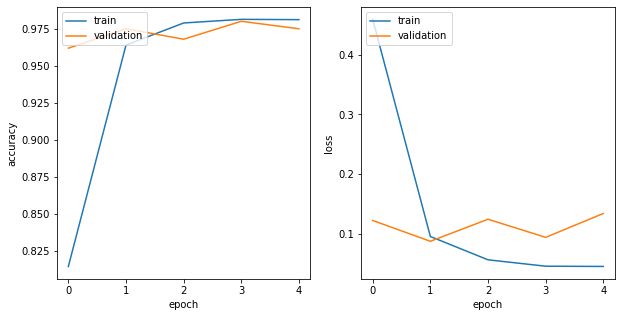

In [150]:
%%time

epochs = 5
batch_size = 128
nNeurons = 1024
nHiddenLayers = 1
input_size = text_transformed_train.shape[1]
output_size = 3
dropout_rate = 0.25
l2_lambda = 0.001

nn_model= nn_model_l2(nNeurons, nHiddenLayers, input_size, output_size, dropout_rate, l2_lambda)

nn_model_fit = nn_model.fit(text_transformed_train, y, epochs=epochs, batch_size=batch_size, validation_data = (text_transformed_test, y_test))
plotTrainingHistory(nn_model_fit) 

In [170]:
nn_acc = nn_model_fit.history['val_accuracy'][-1]
acc.append(nn_acc)
acc_names.append('NN')

### Models accuracy comparison: 

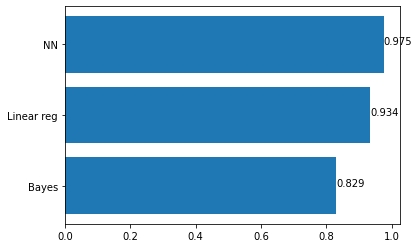

In [175]:
plt.barh(acc_names, acc)

for index, value in enumerate(acc):
    plt.text(value, index,
             str(round(value, 3)))
    
plt.show()